https://pypi.org/project/seg-metrics/

In [3]:
import seg_metrics.seg_metrics as sg
from function_masks_PANNUKE import *

In [4]:
import numpy as np
from sklearn.metrics import jaccard_score
import imageio.v3 as iio

In [5]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice    

In [1]:
PATH_raw = '/media/user/Watson/PanNuke/processed/'
PATH = '/media/user/Watson/PanNuke/normalisation_study/'
methods = ['GeomLoss_sinkhorn_target',
 'Reinhard',
 'Ruifrok',
 'GeomLoss_sinkhorn_gradient',
 'model_GAN',
 'model_Net',
 'Macenko',
 'GeomLoss_sinkhorn_Average',
 'GeomLoss_gaussian_Average',
 'Vahadane',
]
print(methods)
organs = ['Adrenal_gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix', 'Colon', 'Esophagus', 'HeadNeck', 'Kidney', 'Liver', 'Lung', 'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Stomach', 'Testis', 'Thyroid', 'Uterus']print(datasets)

In [8]:
PATH_metrics = '/home/user/Code/Etude_normalisation/PanNuke/metrics/Segmentation/'

# Comparison patches without segmentation/classification

In [24]:
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, psnr, fsim, issm, sam, sre, ssim, uiq
import pandas as pd
import scipy
import scipy.stats

In [25]:
PATH_raw = '/media/user/Watson/PanNuke/processed/'
PATH = '/media/user/Watson/PanNuke/normalisation_study/'

In [26]:
from skimage.metrics import structural_similarity
import math
def _assert_image_shapes_equal(org_img: np.ndarray, pred_img: np.ndarray, metric: str):
    # shape of the image should be like this (rows, cols, bands)
    # Please note that: The interpretation of a 3-dimension array read from rasterio is: (bands, rows, columns) while
    # image processing software like scikit-image, pillow and matplotlib are generally ordered: (rows, columns, bands)
    # in order efficiently swap the axis order one can use reshape_as_raster, reshape_as_image from rasterio.plot
    msg = (
        f"Cannot calculate {metric}. Input shapes not identical. y_true shape ="
        f"{str(org_img.shape)}, y_pred shape = {str(pred_img.shape)}"
    )

    assert org_img.shape == pred_img.shape, msg
    
def function_ssim(org_img: np.ndarray, pred_img: np.ndarray, max_p: int = 4095) -> float:
    """
    Structural Simularity Index
    """
    _assert_image_shapes_equal(org_img, pred_img, "SSIM")

    return structural_similarity(org_img, pred_img, data_range=max_p, channel_axis=2)

def _edge_c(x: np.ndarray, y: np.ndarray):
    """
    Edge correlation coefficient based on Canny detector
    """
    # Use 100 and 200 as thresholds, no indication in the paper what was used
    g = cv2.Canny((x * 0.0625).astype(np.uint8), 100, 200)
    h = cv2.Canny((y * 0.0625).astype(np.uint8), 100, 200)

    g0 = np.mean(g)
    h0 = np.mean(h)

    numerator = np.sum((g - g0) * (h - h0))
    denominator = np.sqrt(np.sum(np.square(g - g0)) * np.sum(np.square(h - h0)))

    return numerator / denominator


def _ehs(x: np.ndarray, y: np.ndarray):
    """
    Entropy-Histogram Similarity measure
    """
    H = (np.histogram2d(x.flatten(), y.flatten()))[0]

    return -np.sum(np.nan_to_num(H * np.log2(H)))

def function_issm(org_img: np.ndarray, pred_img: np.ndarray) -> float:
    """
    Information theoretic-based Statistic Similarity Measure

    Note that the term e which is added to both the numerator as well as the denominator is not properly
    introduced in the paper. We assume the authers refer to the Euler number.
    """
    _assert_image_shapes_equal(org_img, pred_img, "ISSM")

    # Variable names closely follow original paper for better readability
    x = org_img
    y = pred_img
    A = 0.3
    B = 0.5
    C = 0.7

    ehs_val = _ehs(x, y)
    canny_val = _edge_c(x, y)

    numerator = canny_val * ehs_val * (A + B) + math.e
    denominator = A * canny_val * ehs_val + B * ehs_val + C * function_ssim(x, y) + math.e

    return np.nan_to_num(numerator / denominator)

In [7]:
PATH_metrics = '/media/user/Watson/PanNuke/metrics/Quality_image/'


In [8]:
   
if not os.path.exists(PATH_metrics+'df_psnr_PanNuke.csv') :
    df_psnr = pd.DataFrame(datasets)
    df_psnr['Vahadane'] = 0.0
    df_psnr['GeomLoss_sinkhorn_Average'] = 0.
    df_psnr['GeomLoss_sinkhorn_gradient'] = 0.0
    df_psnr['GeomLoss_sinkhorn_target'] = 0.
    df_psnr['Ruifrok'] = 0.0
    df_psnr['Reinhard'] = 0.
    df_psnr['Macenko'] = 0.
    df_psnr['model_GAN'] = 0.0
    df_psnr['model_Net'] = 0.
    df_psnr.rename(columns={0:'datasets'},inplace=True)
    df_psnr.set_index('datasets', inplace=True)
else :
    df_psnr = pd.read_csv(PATH_metrics+'df_psnr_PanNuke.csv')
    df_psnr.rename(columns={'Unnamed: 0':'datasets'},inplace=True)
    df_psnr.set_index('datasets', inplace=True)
    
if not os.path.exists(PATH_metrics+'df_fsim_PanNuke.csv') :
    df_fsim = pd.DataFrame(datasets)
    df_fsim['Vahadane'] = 0.0
    df_fsim['GeomLoss_sinkhorn_Average'] = 0.
    df_fsim['GeomLoss_sinkhorn_gradient'] = 0.0
    df_fsim['GeomLoss_sinkhorn_target'] = 0.
    df_fsim['Ruifrok'] = 0.0
    df_fsim['Reinhard'] = 0.
    df_fsim['Macenko'] = 0.
    df_fsim['model_GAN'] = 0.0
    df_fsim['model_Net'] = 0.
    df_fsim.rename(columns={0:'datasets'},inplace=True)
    df_fsim.set_index('datasets', inplace=True)
else :
    df_fsim = pd.read_csv(PATH_metrics+'df_fsim_PanNuke.csv')
    df_fsim.set_index('datasets', inplace=True)
    
    
if not os.path.exists(PATH_metrics+'df_ssim_PanNuke.csv') :
    df_ssim = pd.DataFrame(datasets)
    df_ssim['Vahadane'] = 0.0
    df_ssim['GeomLoss_sinkhorn_Average'] = 0.
    df_ssim['GeomLoss_sinkhorn_gradient'] = 0.0
    df_ssim['GeomLoss_sinkhorn_target'] = 0.
    df_ssim['GeomLoss_gaussian_Average'] = 0.0
    df_ssim['OT_1D'] = 0.
    df_ssim['Ruifrok'] = 0.0
    df_ssim['Reinhard'] = 0.
    df_ssim['Macenko'] = 0.
    df_ssim['model_GAN'] = 0.0
    df_ssim['model_Net'] = 0.
    df_ssim.rename(columns={0:'datasets'},inplace=True)
    df_ssim.set_index('datasets', inplace=True)
else :
    df_ssim = pd.read_csv(PATH_metrics+'df_ssim_PanNuke.csv')
    df_ssim.set_index('datasets', inplace=True)
    

    
if not os.path.exists(PATH_metrics+'df_pcc_PanNuke.csv') :
    df_pcc = pd.DataFrame(datasets)
    df_pcc['Vahadane'] = 0.0
    df_pcc['GeomLoss_sinkhorn_Average'] = 0.
    df_pcc['GeomLoss_sinkhorn_gradient'] = 0.0
    df_pcc['GeomLoss_sinkhorn_target'] = 0.
    df_pcc['Ruifrok'] = 0.0
    df_pcc['Reinhard'] = 0.
    df_pcc['Macenko'] = 0.
    df_pcc['model_GAN'] = 0.0
    df_pcc['model_Net'] = 0.  
    df_pcc.rename(columns={0:'datasets'},inplace=True)
    df_pcc.set_index('datasets', inplace=True)
else :
    df_pcc = pd.read_csv(PATH_metrics+'df_pcc_PanNuke.csv')
    df_pcc.set_index('datasets', inplace=True)



In [2]:
import matplotlib.image as mpimg
from scipy import stats



patient_count = 0
for dataset in datasets :
    patient_count += 1
    print('----dataset-------', patient_count)
    print(dataset)
    patches = os.listdir(PATH+methods[0]+'/patches/'+dataset)

    for method in methods :
        print('----------', method, '------------')
        if df_pcc.at[dataset, method] !=0 :
            list_psnr = []
            list_fsim = []
            list_ssim = []
            list_pcc = []
            
            for patch in patches : # patches :
              #  count += 1
               # print(count)
                #x = PATH_raw+dataset+'/images/'+patch[:-3]+'png'
                x = PATH+'original/patches/'+dataset+'/'+patch
                y = PATH+method+'/patches/'+dataset+'/'+patch
                try :
                    img_y = mpimg.imread(y)
                except OSError:
                    continue
                img_x = mpimg.imread(x)

               # try :
                rmse_ = rmse(img_y, img_x)
               # print('rmse')
                psnr_ = psnr(img_y, img_x)
               # print('psnr')
                fsim_ = fsim(img_y, img_x)
              #  print('fsim')
                ssim_ = function_ssim(img_y, img_x)
                #print('ssim')
                (pcc, pvalue) = scipy.stats.pearsonr(img_x.flatten(), img_y.flatten())
                    #print('pcc')
#                     except AssertionError :
#                         continue

                list_psnr.append(psnr_)
                list_fsim.append(fsim_)
                list_ssim.append(ssim_)
                list_pcc.append(pcc)

            df_psnr.at[dataset, method] = np.mean(list_psnr)
            df_fsim.at[dataset, method] = np.mean(list_fsim)
            df_ssim.at[dataset, method] = np.mean(list_ssim)
            df_pcc.at[dataset, method] = np.mean(list_pcc)


            df_psnr.to_csv(PATH_metrics+'df_psnr_PanNuke.csv')
            df_fsim.to_csv(PATH_metrics+'df_fsim_PanNuke.csv')
            df_ssim.to_csv(PATH_metrics+'df_ssism_PanNuke.csv')
            df_pcc.to_csv(PATH_metrics+'df_pcc_PanNuke.csv')

        else:
            print([dataset, method], "déja calculé")

In [ ]:
df_psnr.at[dataset, method] = np.mean(list_psnr)
df_fsim.at[dataset, method] = np.mean(list_fsim)
df_ssim.at[dataset, method] = list_ssim.mean()
df_pcc.at[dataset, method] = np.mean(list_pcc)


In [ ]:
for df in [df_fsim,df_psnr,df_pcc,df_ssim] :
    if len(df) == 20 :
    #df.rename(columns={'energy':'GeomLoss_energy','laplacian':'GeomLoss_laplacian','sinkhorn':'GeomLoss_sinkhorn','gaussian':'GeomLoss_gaussian'},inplace=True)
        df.drop([19],inplace=True)

In [ ]:
df_psnr.to_csv('df_psnr.csv')
df_fsim.to_csv('df_fsim.csv')
df_pcc.to_csv('df_pcc.csv')
df_ssim.to_csv('df_ssim.csv')

In [11]:
PATH_metrics = "/media/user/Watson/PanNuke/metrics/Quality_image/"
PATH_savefig = "/media/user/Watson/PanNuke/plot_article/"

In [12]:
df_psnr = pd.read_csv(PATH_metrics+'df_psnr_PanNuke.csv')
df_fsim = pd.read_csv(PATH_metrics+'df_fsim_PanNuke.csv')
df_pcc = pd.read_csv(PATH_metrics+'df_pcc_PanNuke.csv')
df_ssim = pd.read_csv(PATH_metrics+'df_ssim_PanNuke.csv')

In [14]:
for i in [df_psnr, df_fsim,df_pcc,df_ssim] :
    if 'Unnamed: 0' in list(i.columns) :
        i.drop(columns='Unnamed: 0',inplace=True)
    i.drop(columns=['GeomLoss_gaussian_Average', 'OT_1D'], inplace=True)
    i.rename(columns={'model_GAN':'StainGAN','model_Net':'StainNet'},inplace=True)
    i.set_index('datasets',inplace=True)

In [15]:
df_ssim

,Vahadane,GeomLoss_sinkhorn_Average,GeomLoss_sinkhorn_gradient,GeomLoss_sinkhorn_target,Ruifrok,Reinhard,Macenko,StainGAN,StainNet
datasets,,,,,,,,,
Adrenal_gland,0.975459,0.965560,0.947303,0.966017,0.964167,0.965544,0.974573,0.953115,0.896748
Bile-duct,0.979608,0.963743,0.944739,0.962955,0.970407,0.962511,0.979851,0.955625,0.890616
Bladder,0.958601,0.956839,0.948399,0.949864,0.954740,0.947746,0.958430,0.961680,0.906811
Breast,0.965901,0.974158,0.988839,0.940748,0.964780,0.939057,0.962261,0.986186,0.940790
Cervix,0.968689,0.939246,0.905526,0.954035,0.949645,0.951751,0.965605,0.918713,0.859001
Colon,0.939222,0.957452,0.978343,0.921487,0.940489,0.919042,0.930445,0.959389,0.931656
Esophagus,0.966498,0.979966,0.969427,0.967322,0.966348,0.963995,0.973091,0.966419,0.904178
HeadNeck,0.945639,0.962374,0.978749,0.929341,0.951484,0.927616,0.949942,0.968569,0.940505
Kidney,0.973140,0.962525,0.954991,0.956696,0.962177,0.956521,0.975040,0.947514,0.909951


# Z score

In [44]:
df_zscore = (df_psnr - df_psnr.mean())/df_psnr.std()
df_zscore.to_csv('/media/user/Watson/PanNuke/metrics/Quality_image_zscore/df_psnr_PanNuke.csv')

df_zscore = (df_fsim - df_fsim.mean())/df_fsim.std()
df_zscore.to_csv('/media/user/Watson/PanNuke/metrics/Quality_image_zscore/df_fsim_PanNuke.csv')


df_zscore = (df_pcc - df_pcc.mean())/df_pcc.std()
df_zscore.to_csv('/media/user/Watson/PanNuke/metrics/Quality_image_zscore/df_pcc_PanNuke.csv')

df_zscore = (df_ssim - df_ssim.mean())/df_ssim.std()
df_zscore.to_csv('/media/user/Watson/PanNuke/metrics/Quality_image_zscore/df_ssim_PanNuke.csv')

# Plot & savefig

In [15]:
#PATH_metrics_zscore = '/media/user/Watson/PanNuke/metrics/Quality_image_zscore/'
PATH_savefig = "/media/user/Watson/PanNuke/plot_article/Quality_image/without_zscore/"

In [92]:
df_psnr = pd.read_csv(PATH_metrics_zscore+'df_psnr_PanNuke.csv')
df_fsim = pd.read_csv(PATH_metrics_zscore+'df_fsim_PanNuke.csv')
df_sre = pd.read_csv(PATH_metrics_zscore+'df_sre_PanNuke.csv')
df_sam = pd.read_csv(PATH_metrics_zscore+'df_sam_PanNuke.csv')
df_pcc = pd.read_csv(PATH_metrics_zscore+'df_pcc_PanNuke.csv')
df_ssim = pd.read_csv(PATH_metrics_zscore+'df_ssim_PanNuke.csv')

In [93]:
for i in [df_rmse,df_psnr, df_fsim,df_sre,df_sam,df_pcc,df_ssim] :
    if 'Unnamed: 0' in list(i.columns) :
        i.drop(columns='Unnamed: 0',inplace=True)
    i.rename(columns={'model_GAN':'StainGAN','model_Net':'StainNet'},inplace=True)
    i.set_index('datasets',inplace=True)

In [94]:
df_rmse

,Vahadane,GeomLoss_sinkhorn_Average,GeomLoss_sinkhorn_gradient,GeomLoss_sinkhorn_target,OT_1D,GeomLoss_gaussian_Average,Ruifrok,Reinhard,Macenko,StainGAN,StainNet
datasets,,,,,,,,,,,
Adrenal_gland,-0.250341,-0.190481,0.051295,-0.239085,-0.000617,-0.176912,0.322444,-0.254332,0.073599,0.495358,0.505211
Bile-duct,-1.115232,-0.399555,0.262608,-0.401014,-0.279450,-0.402876,-0.691539,-0.409930,-0.632084,0.029966,-0.060328
Bladder,0.261313,0.830913,0.186286,0.535263,0.690415,0.807415,1.064082,0.517729,0.699933,-0.450059,-0.998202
Breast,0.683429,0.275470,-1.941198,1.150501,-0.441735,0.149218,-0.010204,1.105814,0.834079,-2.176113,-1.959313
Cervix,-0.337396,0.547631,1.456982,-0.170485,1.315092,0.576281,0.917970,-0.126384,0.000797,2.184752,1.573094
Colon,2.410965,1.902549,-1.041898,2.320868,0.985361,1.795130,1.511958,2.341168,2.558520,0.037894,-1.296974
Esophagus,0.240067,-1.111848,-0.633909,-0.317361,-1.113253,-1.260582,-0.436156,-0.299978,0.154906,-0.155440,0.533874
HeadNeck,2.091744,1.559475,-0.886802,1.919423,0.910153,1.367030,1.916134,1.958644,1.680572,-0.379685,-1.591684
Kidney,-0.497235,0.089858,-0.683861,0.219867,-0.064050,0.185124,0.212392,0.201287,-0.305026,0.656735,-0.072935


In [18]:
df_ssim.loc['median'] = df_ssim.median()

df_ssim = df_ssim.sort_values(by = 'median', axis = 1) 
df_ssim #= df_ssim[:-1]

,StainNet,GeomLoss_sinkhorn_gradient,StainGAN,Reinhard,GeomLoss_sinkhorn_target,GeomLoss_sinkhorn_Average,Ruifrok,Vahadane,Macenko
datasets,,,,,,,,,
Adrenal_gland,0.896748,0.947303,0.953115,0.965544,0.966017,0.965560,0.964167,0.975459,0.974573
Bile-duct,0.890616,0.944739,0.955625,0.962511,0.962955,0.963743,0.970407,0.979608,0.979851
Bladder,0.906811,0.948399,0.961680,0.947746,0.949864,0.956839,0.954740,0.958601,0.958430
Breast,0.940790,0.988839,0.986186,0.939057,0.940748,0.974158,0.964780,0.965901,0.962261
Cervix,0.859001,0.905526,0.918713,0.951751,0.954035,0.939246,0.949645,0.968689,0.965605
Colon,0.931656,0.978343,0.959389,0.919042,0.921487,0.957452,0.940489,0.939222,0.930445
Esophagus,0.904178,0.969427,0.966419,0.963995,0.967322,0.979966,0.966348,0.966498,0.973091
HeadNeck,0.940505,0.978749,0.968569,0.927616,0.929341,0.962374,0.951484,0.945639,0.949942
Kidney,0.909951,0.954991,0.947514,0.956521,0.956696,0.962525,0.962177,0.973140,0.975040


In [19]:
df_ssim.loc['median'].round(2)

StainNet                      0.90
GeomLoss_sinkhorn_gradient    0.95
StainGAN                      0.96
Reinhard                      0.96
GeomLoss_sinkhorn_target      0.96
GeomLoss_sinkhorn_Average     0.97
Ruifrok                       0.97
Vahadane                      0.97
Macenko                       0.98
Name: median, dtype: float64

/home/user/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


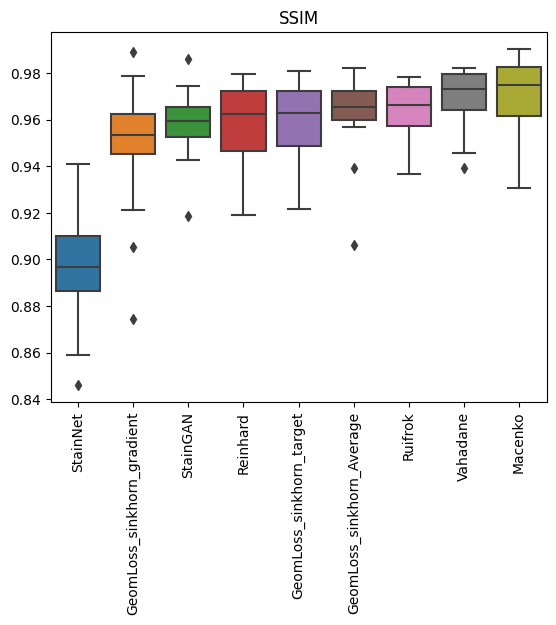

In [20]:
import seaborn as sns
ax = sns.boxplot(data= df_ssim)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('SSIM')
plt.savefig(PATH_savefig+'SSIM.svg', format = 'svg', dpi = 20000, bbox_inches='tight')


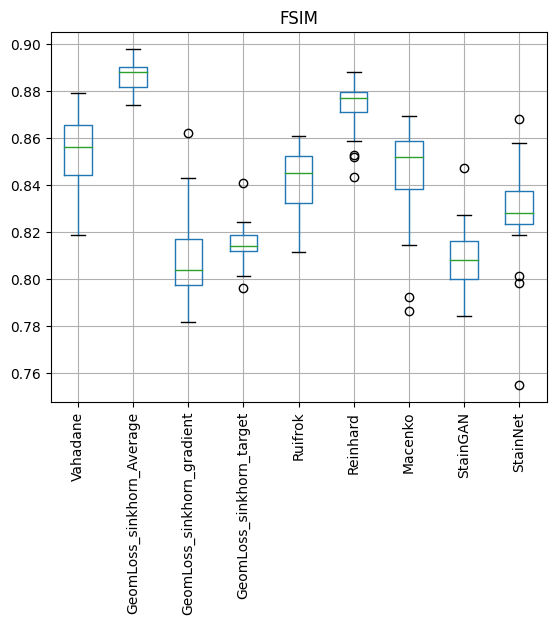

In [21]:
df_fsim.boxplot(column=list(df_fsim.columns))
title_boxplot = 'FSIM'
plt.title( title_boxplot )
#plt.suptitle('') # that's what you're after
plt.xticks(rotation=90)
plt.savefig(PATH_savefig+'FSIM_PanNuke.svg', format = 'svg', dpi = 1200)
plt.show()


In [22]:
df_ssim.loc['median'] = df_ssim.median()

df_ssim = df_ssim.sort_values(by = 'median', axis = 1) 
df_ssim.loc['median'].round(2)#= df_fsim[:-1]

StainNet                      0.90
GeomLoss_sinkhorn_gradient    0.95
StainGAN                      0.96
Reinhard                      0.96
GeomLoss_sinkhorn_target      0.96
GeomLoss_sinkhorn_Average     0.97
Ruifrok                       0.97
Vahadane                      0.97
Macenko                       0.98
Name: median, dtype: float64

In [23]:
df_ssim.loc['mean'] = df_ssim.mean()

df_ssim = df_ssim.sort_values(by = 'mean', axis = 1) 
df_ssim.loc['mean'].round(2)#= df_fsim[:-1]

StainNet                      0.90
GeomLoss_sinkhorn_gradient    0.95
Reinhard                      0.96
StainGAN                      0.96
GeomLoss_sinkhorn_target      0.96
GeomLoss_sinkhorn_Average     0.96
Ruifrok                       0.96
Vahadane                      0.97
Macenko                       0.97
Name: mean, dtype: float64

In [24]:
df_fsim.loc['median'] = df_fsim.median()

df_fsim = df_fsim.sort_values(by = 'median', axis = 1) 
df_fsim.loc['median'].round(2)#= df_fsim[:-1]

GeomLoss_sinkhorn_gradient    0.80
StainGAN                      0.81
GeomLoss_sinkhorn_target      0.81
StainNet                      0.83
Ruifrok                       0.85
Macenko                       0.85
Vahadane                      0.86
Reinhard                      0.88
GeomLoss_sinkhorn_Average     0.89
Name: median, dtype: float64

In [25]:
df_fsim.loc['mean'] = df_fsim.mean()

df_fsim = df_fsim.sort_values(by = 'mean', axis = 1) 
df_fsim.loc['mean'].round(2)#= df_fsim[:-1]

GeomLoss_sinkhorn_gradient    0.81
StainGAN                      0.81
GeomLoss_sinkhorn_target      0.82
StainNet                      0.83
Ruifrok                       0.84
Macenko                       0.84
Vahadane                      0.85
Reinhard                      0.87
GeomLoss_sinkhorn_Average     0.89
Name: mean, dtype: float64

In [26]:
df_pcc.loc['median'] = df_pcc.median()

df_pcc = df_pcc.sort_values(by = 'median', axis = 1) 
df_pcc.loc['median'].round(2)#= df_fsim[:-1]

Ruifrok                       0.85
StainGAN                      0.88
StainNet                      0.90
GeomLoss_sinkhorn_Average     0.94
GeomLoss_sinkhorn_gradient    0.95
Vahadane                      0.95
GeomLoss_sinkhorn_target      0.96
Reinhard                      0.96
Macenko                       0.97
Name: median, dtype: float64

In [27]:
df_pcc.loc['mean'] = df_pcc.mean()

df_pcc = df_pcc.sort_values(by = 'mean', axis = 1) 
df_pcc.loc['mean'].round(2)#= df_fsim[:-1]

Ruifrok                       0.85
StainGAN                      0.88
StainNet                      0.90
GeomLoss_sinkhorn_Average     0.93
Vahadane                      0.93
GeomLoss_sinkhorn_gradient    0.95
GeomLoss_sinkhorn_target      0.95
Reinhard                      0.96
Macenko                       0.96
Name: mean, dtype: float64

In [28]:
df_psnr.loc['median'] = df_psnr.median()

df_psnr = df_psnr.sort_values(by = 'median', axis = 1) 
df_psnr.loc['median'].round(2)#= df_fsim[:-1]

StainNet                      38.14
Ruifrok                       41.87
GeomLoss_sinkhorn_gradient    41.89
GeomLoss_sinkhorn_target      42.79
Reinhard                      42.83
StainGAN                      43.30
GeomLoss_sinkhorn_Average     43.30
Vahadane                      46.36
Macenko                       46.59
Name: median, dtype: float64

In [29]:
df_psnr.loc['mean'] = df_psnr.mean()

df_psnr = df_psnr.sort_values(by = 'mean', axis = 1) 
df_psnr.loc['mean'].round(2)#= df_fsim[:-1]

StainNet                      38.35
Ruifrok                       42.00
GeomLoss_sinkhorn_gradient    42.23
GeomLoss_sinkhorn_target      42.83
Reinhard                      42.83
GeomLoss_sinkhorn_Average     42.86
StainGAN                      43.31
Vahadane                      45.56
Macenko                       45.83
Name: mean, dtype: float64

/home/user/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


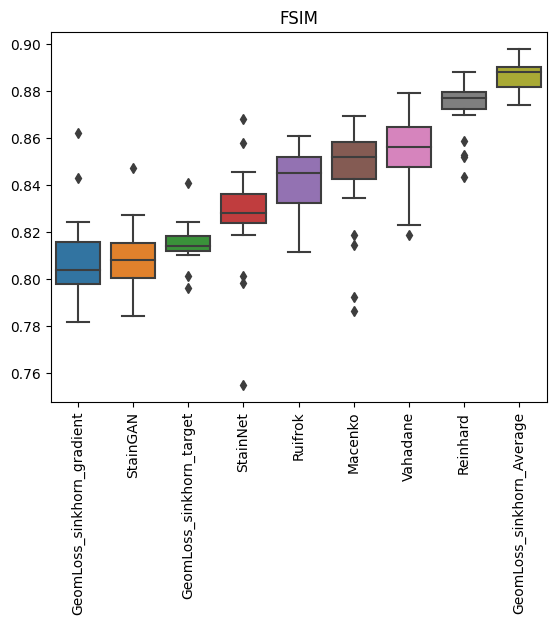

In [30]:
import seaborn as sns
ax = sns.boxplot(data= df_fsim)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('FSIM')
plt.savefig(PATH_savefig+'FSIM.svg', format = 'svg', dpi = 20000, bbox_inches='tight')


In [31]:
df_fsim.loc['median'] = df_fsim.median()

df_fsim = df_fsim.sort_values(by = 'median', axis = 1) 
df_fsim #= df_fsim[:-1]

,GeomLoss_sinkhorn_gradient,StainGAN,GeomLoss_sinkhorn_target,StainNet,Ruifrok,Macenko,Vahadane,Reinhard,GeomLoss_sinkhorn_Average
datasets,,,,,,,,,
Adrenal_gland,0.803237,0.799479,0.816766,0.823690,0.835290,0.849968,0.858726,0.875590,0.885818
Bile-duct,0.799931,0.813460,0.812428,0.818445,0.850905,0.859443,0.876242,0.879702,0.887742
Bladder,0.792291,0.804439,0.795983,0.829891,0.821718,0.818651,0.847589,0.852780,0.888175
Breast,0.862063,0.847023,0.840783,0.867936,0.858753,0.857837,0.848690,0.885002,0.896597
Cervix,0.788538,0.786197,0.812584,0.798431,0.830878,0.834208,0.852922,0.858564,0.880618
Colon,0.843099,0.800543,0.815772,0.857858,0.826212,0.792086,0.822931,0.851783,0.890167
Esophagus,0.818170,0.814890,0.820432,0.839356,0.851715,0.842585,0.866205,0.876865,0.897793
HeadNeck,0.821783,0.788719,0.801067,0.845612,0.811606,0.786293,0.818580,0.843394,0.889164
Kidney,0.812388,0.792540,0.816641,0.827514,0.838785,0.858028,0.864631,0.869854,0.881458


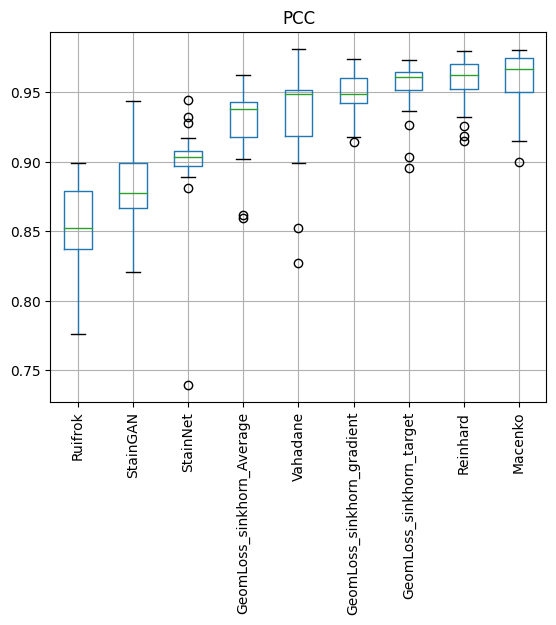

In [33]:
df_pcc.boxplot(column=list(df_pcc.columns))
title_boxplot = 'PCC'
plt.title( title_boxplot )
#plt.suptitle('') # that's what you're after
plt.xticks(rotation=90)
plt.savefig(PATH_savefig+'PCC_PanNuke.svg', format = 'svg', dpi = 1200)
plt.show()


In [34]:
df_pcc.loc['mean'] = df_pcc.mean()

df_pcc = df_pcc.sort_values(by = 'mean', axis = 1) 
df_pcc = df_pcc[:-1]

/home/user/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


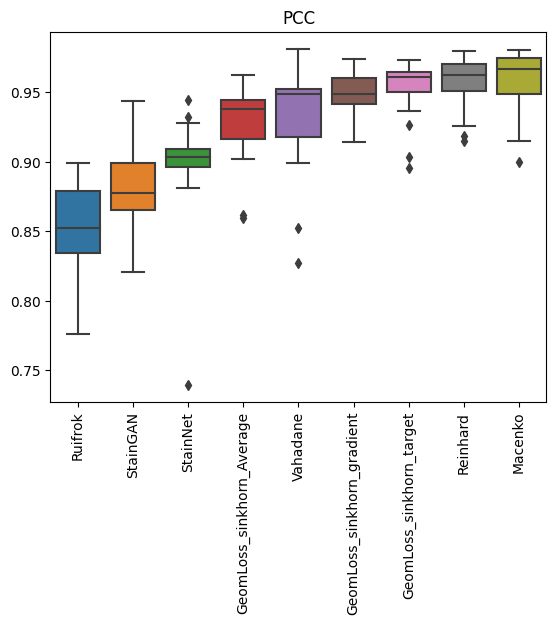

In [35]:
import seaborn as sns
ax = sns.boxplot(data= df_pcc)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('PCC')
plt.savefig(PATH_savefig+'PCC.svg', format = 'svg', dpi = 20000, bbox_inches='tight')


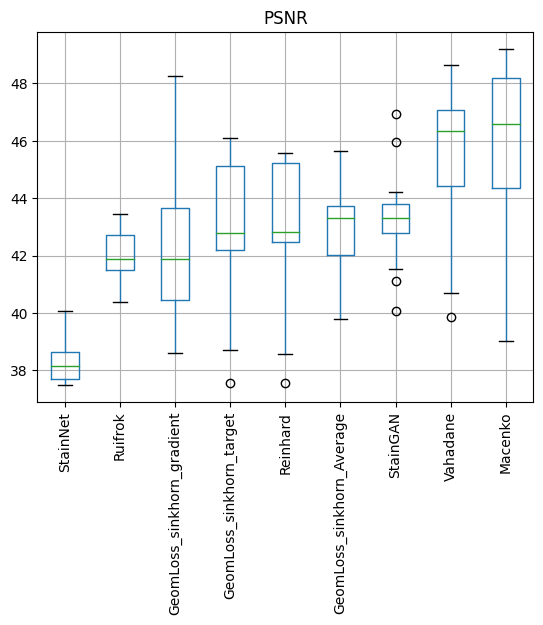

In [36]:
df_psnr.boxplot(column=list(df_psnr.columns))
title_boxplot = 'PSNR'
plt.title( title_boxplot )
#plt.suptitle('') # that's what you're after
plt.xticks(rotation=90)
plt.savefig(PATH_savefig+'PSNR_PanNuke.svg', format = 'svg', dpi = 1200)
plt.show()


In [37]:
df_psnr.loc['mean'] = df_psnr.mean()

df_psnr = df_psnr.sort_values(by = 'mean', axis = 1) 
df_psnr = df_psnr[:-1]

/home/user/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


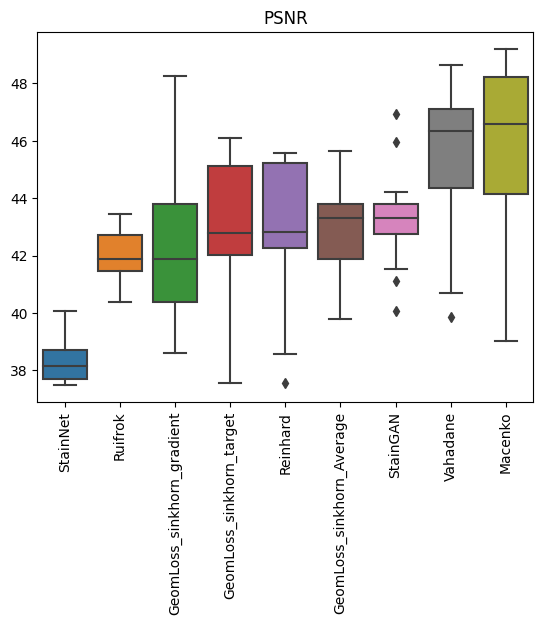

In [38]:
import seaborn as sns
ax = sns.boxplot(data= df_psnr)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('PSNR')
plt.savefig(PATH_savefig+'PSNR.svg', format = 'svg', dpi = 20000, bbox_inches='tight')
